In [6]:
import jax.numpy as jnp
import numpy as np
import jax
from flax import nnx
import optax
from flax.training import train_state



In [7]:
# generate some data for the problem to approx y = x^2
np.random.seed(42)
n_train_data = 100
n_test_data = 20

train_data = np.array([(i, i**2 + np.random.normal(0.0, 0.01)) for i in np.random.normal(0.0, 1.0, n_train_data)])
test_data = np.array([(i, i**2) for i in np.random.normal(0.0, 1.0, n_test_data)])

print(train_data.shape)
print(test_data.shape)


train_x = jnp.array(train_data[:, 0:1])
train_y = jnp.array(train_data[:, 1])
test_x  = jnp.array(test_data[:, 0:1])
test_y  = jnp.array(test_data[:, 1])


(100, 2)
(20, 2)


In [8]:
# ---------------------------------------------------------
# Define a simple NN
# ---------------------------------------------------------
class SimpleNN(nnx.Module):
    def __init__(self, n_features=1, n_hidden=10, n_targets=1, *, rngs: nnx.Rngs):
        self.layer1 = nnx.Linear(n_features, n_hidden, rngs=rngs)
        self.layer2 = nnx.Linear(n_hidden, n_hidden, rngs=rngs)
        self.layer3 = nnx.Linear(n_hidden, n_targets, rngs=rngs)

    def __call__(self, x):
        x = nnx.relu(self.layer1(x))
        x = nnx.relu(self.layer2(x))
        return self.layer3(x)

# ---------------------------------------------------------
# Setup model, split into graphdef + state
# ---------------------------------------------------------
model = SimpleNN(rngs=nnx.Rngs(0))
graphdef, state = nnx.split(model)

# Extract only the parameters from state
params = state.filter(nnx.Param)

# ---------------------------------------------------------
# Loss and train step
# ---------------------------------------------------------
def mse_loss(params, graphdef, state, x, y):
    # update state with current params
    new_state = state.merge(params)
    m = nnx.merge(graphdef, new_state)
    preds = m(x)
    return jnp.mean((preds.squeeze() - y) ** 2)

tx = optax.adam(1e-2)  # slightly higher LR for faster convergence
opt_state = tx.init(params)

@jax.jit
def train_step(params, opt_state, graphdef, state, x, y):
    def loss_fn(p):
        return mse_loss(p, graphdef, state, x, y)
    grads = jax.grad(loss_fn)(params)
    updates, opt_state = tx.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state

# ---------------------------------------------------------
# Training loop
# ---------------------------------------------------------
n_epochs = 200
train_hist, test_hist = [], []

for epoch in range(1, n_epochs + 1):
    params, opt_state = train_step(params, opt_state, graphdef, state, train_x, train_y)

    train_loss = mse_loss(params, graphdef, state, train_x, train_y)
    test_loss  = mse_loss(params, graphdef, state, test_x, test_y)

    train_hist.append(float(train_loss))
    test_hist.append(float(test_loss))

    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d}: Train {train_loss:.6f}, Test {test_loss:.6f}")


Epoch   1: Train 2.669652, Test 7.499406
Epoch  20: Train 0.409557, Test 5.440093
Epoch  40: Train 0.097567, Test 3.413939
Epoch  60: Train 0.064740, Test 2.924632
Epoch  80: Train 0.039724, Test 2.954065
Epoch 100: Train 0.021734, Test 2.734259
Epoch 120: Train 0.012063, Test 2.493087
Epoch 140: Train 0.006971, Test 2.345949
Epoch 160: Train 0.004418, Test 2.269948
Epoch 180: Train 0.003197, Test 2.212618
Epoch 200: Train 0.002295, Test 2.144271


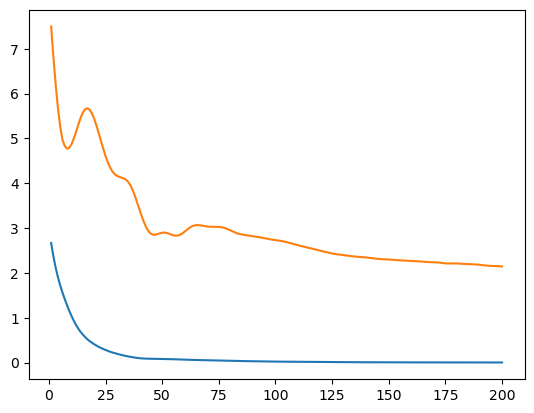

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.plot(np.arange(1, n_epochs+1), train_hist)
plt.plot(np.arange(1, n_epochs+1), test_hist)

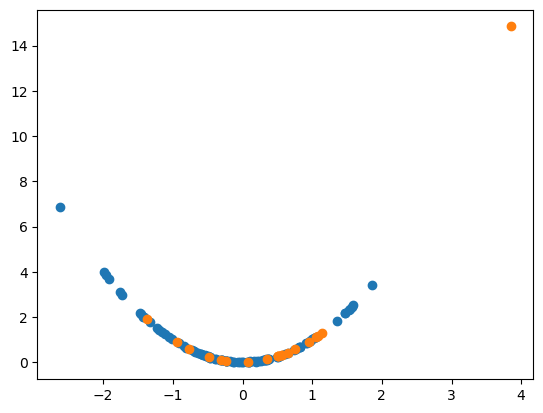

In [10]:
new_state = state.merge(params)

plt.scatter(train_data[:, 0], train_data[:,1])
plt.scatter(test_data[:,0], test_data[:,1])




In [11]:
full_range = jnp.array(np.arange(-4, 4, 0.001)).reshape(-1,1)
new_state = state.merge(params)
m = nnx.merge(graphdef, new_state)
preds = m(full_range)

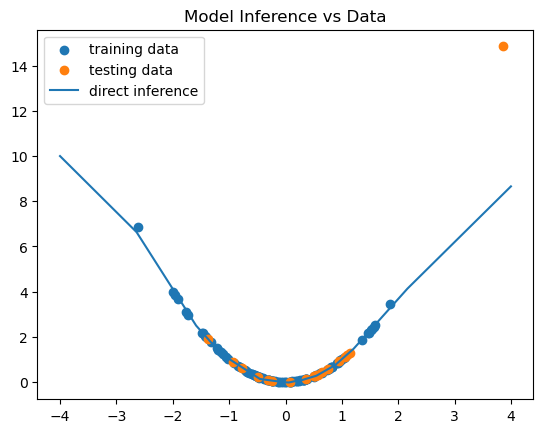

In [12]:
new_state = state.merge(params)

plt.scatter(train_data[:, 0], train_data[:,1], label = "training data")
plt.scatter(test_data[:,0], test_data[:,1], label = "testing data")
plt.plot(full_range, preds, label = "direct inference")
plt.title("Model Inference vs Data")
plt.legend()